In [5]:
#!rm -r variables

In [17]:
import tensorflow as tf
assert tf.__version__.startswith('2')
import zipfile
import os
os.environ['KERAS_BACKEND']='tensorflow'
import numpy as np
import matplotlib.pyplot as plt
tf.__version__
import datetime
# import pydot
# import graphviz

In [18]:
# files = zipfile.ZipFile('scenephoto.zip', 'r')
# files.extractall(os.getcwd())
# files.close()

In [19]:
base_dir = "./scenephoto"
base_dir

'./scenephoto'

In [20]:
IMAGE_SIZE = 224
BATCH_SIZE = 20

In [21]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rescale=1./255,
validation_split=0.1)

In [22]:
train_generator = datagen.flow_from_directory(
base_dir,
target_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE,
subset='training')

Found 945 images belonging to 7 classes.


In [23]:
val_generator = datagen.flow_from_directory(
base_dir,
target_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE,
subset='validation')

Found 105 images belonging to 7 classes.


In [24]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((20, 224, 224, 3), (20, 7))

In [25]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)

{'desert': 0, 'firework': 1, 'flowers': 2, 'sky': 3, 'sunset': 4, 'waterfall': 5, 'wood': 6}


In [26]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
include_top=False,
weights='imagenet')
len(base_model.layers)
base_model.summary()
base_model.etrainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [27]:
model = tf.keras.Sequential([
base_model,
tf.keras.layers.Conv2D(32, 3, activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(7, activation='softmax')
])

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 2,626,887
Trainable params: 2,592,775
Non-trainable params: 34,112
_________________________________________________________________


In [30]:
print('Number of trainable variables = {}'.format(
len(model.trainable_variables)))

Number of trainable variables = 160


In [31]:
log_dir = "./tf_dir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[tensorboard_callback])

Train for 48 steps, validate for 6 steps
Epoch 1/20
48/48 [==============================] - 31s 645ms/step - loss: 0.5926 - accuracy: 0.8381 - val_loss: 14.7292 - val_accuracy: 0.3619
Epoch 2/20
48/48 [==============================] - 22s 462ms/step - loss: 0.4456 - accuracy: 0.9132 - val_loss: 9.3235 - val_accuracy: 0.3333
Epoch 3/20
48/48 [==============================] - 22s 457ms/step - loss: 0.4321 - accuracy: 0.9026 - val_loss: 12.9558 - val_accuracy: 0.2857
Epoch 4/20
48/48 [==============================] - 22s 459ms/step - loss: 0.1480 - accuracy: 0.9714 - val_loss: 4.4170 - val_accuracy: 0.3143
Epoch 5/20
48/48 [==============================] - 21s 446ms/step - loss: 0.0808 - accuracy: 0.9757 - val_loss: 9.0086 - val_accuracy: 0.3714
Epoch 6/20
48/48 [==============================] - 22s 453ms/step - loss: 0.2265 - accuracy: 0.9513 - val_loss: 3.5142 - val_accuracy: 0.3810
Epoch 7/20
48/48 [==============================] - 22s 458ms/step - loss: 0.1353 - accuracy: 0.960

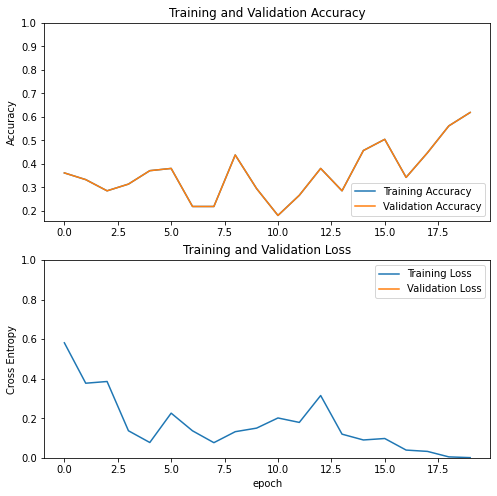

In [34]:
aacc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss') 
plt.xlabel('epoch')
plt.show()

In [35]:
base_model.trainable=True
print(len(base_model.layers))

155


In [36]:
fine_tune_at = 100

In [37]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 2,626,887
Trainable params: 2,231,495
Non-trainable params: 395,392
_________________________________________________________________


In [40]:
print('Number of trainable variables = {}'.format(
len(model.trainable_variables)))

Number of trainable variables = 60


In [41]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Train for 48 steps, validate for 6 steps
Epoch 1/5
48/48 [==============================] - 23s 473ms/step - loss: 6.5529e-04 - accuracy: 1.0000 - val_loss: 2.3977 - val_accuracy: 0.6000
Epoch 2/5
48/48 [==============================] - 18s 367ms/step - loss: 3.9282e-04 - accuracy: 1.0000 - val_loss: 2.5681 - val_accuracy: 0.6286
Epoch 3/5
48/48 [==============================] - 18s 370ms/step - loss: 3.2714e-04 - accuracy: 1.0000 - val_loss: 2.7513 - val_accuracy: 0.6667
Epoch 4/5
48/48 [==============================] - 18s 378ms/step - loss: 2.7875e-04 - accuracy: 1.0000 - val_loss: 2.9203 - val_accuracy: 0.6857
Epoch 5/5
48/48 [==============================] - 18s 369ms/step - loss: 2.6567e-04 - accuracy: 1.0000 - val_loss: 3.0894 - val_accuracy: 0.6762


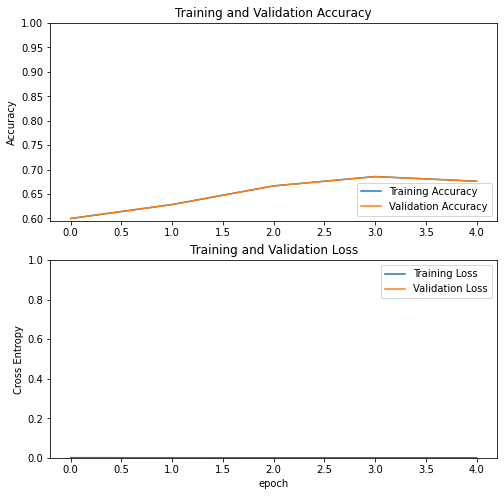

In [42]:
aacc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss') 
plt.xlabel('epoch')
plt.show()

In [44]:
saved_model_path = "./mymodels"

tf.saved_model.save(model,saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mymodels/assets


In [49]:
saved_model_path = "./mymodels"
out_path=r"./model.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
with open(out_path,'wb') as f:
    f.write(tflite_model)